# Expense Forecasting Model

The Monthly Expense Forecasting Model is designed to predict a user’s upcoming month’s total spending based on their historical financial transactions. Using a cleaned dataset of filtered expense transactions (excluding income and transfers), the model aggregates data at the monthly level and applies lag and rolling mean features to capture temporal patterns and seasonality. A Ridge regression model is used as the primary estimator due to its robustness against small datasets and multicollinearity, while a TimeSeriesSplit cross-validation ensures realistic backtesting over time without data leakage. The model outputs a single forecast value representing the expected next-month expenditure. To quantify prediction uncertainty, Quantile Regression is used to generate P50 (median) and P90 (upper-bound) budget bands. These provide an interpretable confidence range that can guide users toward more informed financial planning. The model’s average backtest Mean Absolute Error (MAE) reflects how closely predictions align with historical data, while the budget bands indicate possible spending variability.


In [1]:
# Cell 1: Imports & Config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Do not set styles or colors per constraints
pd.set_option("display.max_rows", 100)


In [2]:
# Cell 2: Paths (edit these for your environment)
CSV_PATH = "/Users/arrju/Documents/CS595/txn-category-ml/data/expenses_data.csv"
CATEGORIES_JSON = "/Users/arrju/Documents/CS595/txn-category-ml/data/categories.json"  # optional

# Columns expected: id,name,merchant_name,amount,transactionDate,category_id,category_text,cat_name,is_income


In [4]:
# Cell 3: Load CSV + basic cleaning helpers
def coerce_amount(s: pd.Series) -> pd.Series:
    return (
        s.astype(str)
         .str.replace("[,$]", "", regex=True)
         .str.replace(r"\((.*)\)", r"-\1", regex=True)   # (123.45) -> -123.45
         .str.replace("\u2212", "-", regex=False)        # − -> -
         .astype(float)
    )

def parse_date(s: pd.Series) -> pd.Series:
    return pd.to_datetime(s, errors="coerce", utc=True).dt.tz_localize(None)

df = pd.read_csv(CSV_PATH)
assert {"amount","transactionDate"}.issubset(df.columns), "CSV missing required columns."

df["amount"] = coerce_amount(df["amount"])
df["event_date"] = parse_date(df["transactionDate"])
df = df.dropna(subset=["event_date"]).copy()

# Exclude income/transfers if labeled (cat_name or is_income)
if "cat_name" in df.columns:
    df = df[~df["cat_name"].isin(["INCOME","TRANSFER_IN","TRANSFER_OUT"])].copy()
elif "is_income" in df.columns:
    df = df[df["is_income"].astype(str).str.lower().isin(["false","0","no"])].copy()

# Prepare month key
df["year_month"] = df["event_date"].dt.to_period("M").dt.to_timestamp()

print(df.head())
print(f"Rows after filtering: {len(df)}")


                                     id                    name  \
0  d2b8997c-770f-405d-beb0-21126353b4b3      Home & Furnishings   
2  8f6d7115-d7b0-4bbe-92a4-2d40a74457e6  House Rent & Utilities   
3  3721ce64-54be-4804-bac6-955eaaa3a520                  Coffee   
4  06db5a90-4aa0-42d0-aa3f-c955b55f14c7             Mobile Bill   
5  6ce3cfbe-d1f5-41f6-addf-75b2c66b054a               WiFi Bill   

   merchant_name  amount         transactionDate  category_id  \
0     Home Depot  149.97  2022-11-02 17:00:00-07           54   
2  Property Mgmt  848.91  2022-11-03 16:00:00-07           34   
3  Dunkin Donuts    5.09  2022-11-05 17:00:00-07           24   
4        Verizon   37.52  2022-11-05 19:00:00-07           64   
5        Comcast   29.52  2022-11-06 14:00:00-08           43   

                           category_text            cat_name is_income  \
0             HOME_IMPROVEMENT_FURNITURE    HOME_IMPROVEMENT         f   
2                RENT_AND_UTILITIES_RENT  RENT_AND_UTILITI

2) EDA #1 — Monthly Expense Trend Analysis

In [5]:
# Cell 4: Aggregate monthly totals
monthly = (
    df.groupby("year_month", as_index=False)["amount"]
      .sum()
      .sort_values("year_month")
)

# Fill missing months with NaN for visual continuity
monthly = monthly.set_index("year_month").asfreq("MS").reset_index()

# Compute moving averages for context (3,6,12 months)
for w in [3,6,12]:
    monthly[f"ma_{w}"] = monthly["amount"].rolling(w).mean()

monthly.tail(12)


,year_month,amount,ma_3,ma_6,ma_12
24,2024-11-01,3098.19,2410.963333,2301.641667,2320.332500
25,2024-12-01,1842.38,2335.833333,2344.336667,2338.993333
26,2025-01-01,2066.48,2335.683333,2424.030000,2339.023333
27,2025-02-01,3239.73,2382.863333,2396.913333,2407.655833
28,2025-03-01,735.76,2013.990000,2174.911667,2201.095833
29,2025-04-01,1772.52,1916.003333,2125.843333,2055.735000
30,2025-05-01,2700.18,1736.153333,2059.508333,2180.575000
31,2025-06-01,3082.63,2518.443333,2266.216667,2305.276667
32,2025-07-01,3294.52,3025.776667,2470.890000,2447.460000
33,2025-08-01,1835.10,2737.416667,2236.785000,2316.849167


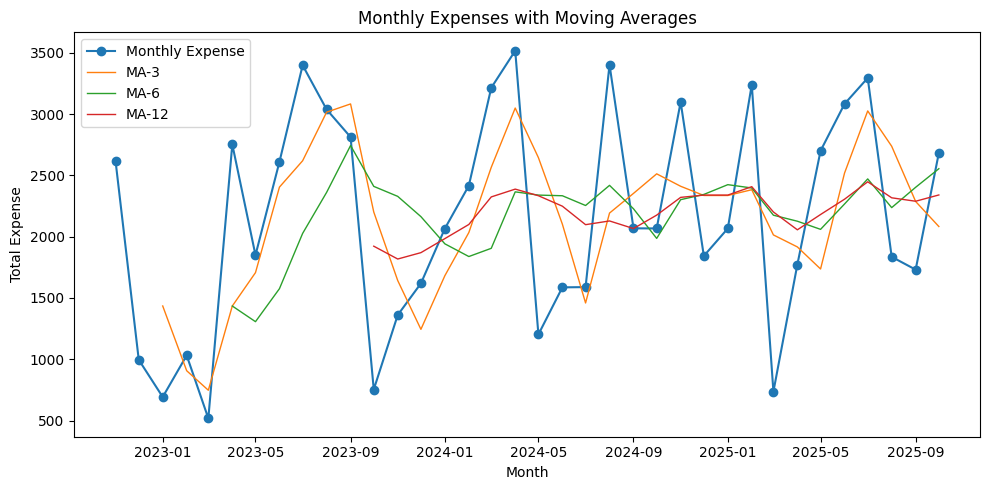

In [6]:
# Cell 5: Plot monthly expense + moving averages
plt.figure(figsize=(10,5))
plt.plot(monthly["year_month"], monthly["amount"], marker="o", linewidth=1.5, label="Monthly Expense")
plt.plot(monthly["year_month"], monthly["ma_3"], linewidth=1.0, label="MA-3")
plt.plot(monthly["year_month"], monthly["ma_6"], linewidth=1.0, label="MA-6")
plt.plot(monthly["year_month"], monthly["ma_12"], linewidth=1.0, label="MA-12")
plt.xlabel("Month")
plt.ylabel("Total Expense")
plt.title("Monthly Expenses with Moving Averages")
plt.legend()
plt.tight_layout()
plt.show()


EDA #2 — Category-Wise Expense Distribution

,cat_name,amount
7,RENT_AND_UTILITIES,32421.84
1,FOOD_AND_DRINK,15705.04
9,TRAVEL,6256.27
3,GENERAL_SERVICES,6191.15
2,GENERAL_MERCHANDISE,5671.67
8,TRANSPORTATION,4401.16
6,LOAN_PAYMENTS,2669.28
5,HOME_IMPROVEMENT,2304.32
0,ENTERTAINMENT,918.10
4,GOVERNMENT_AND_NON_PROFIT,712.64


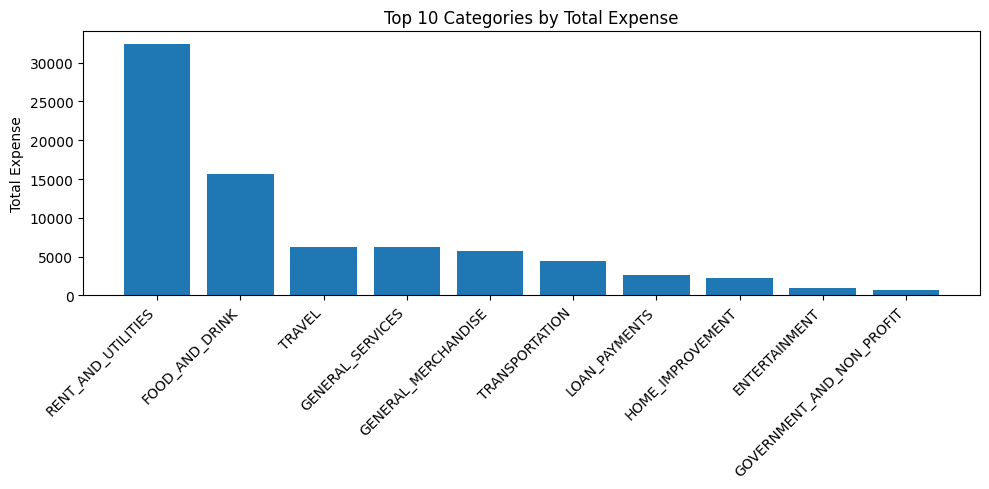

In [8]:
# Cell 6: Category distribution (top N)
if "cat_name" in df.columns:
    cat_month = (
        df.groupby(["year_month","cat_name"], as_index=False)["amount"].sum()
          .sort_values(["year_month","amount"], ascending=[True,False])
    )

    cat_total = df.groupby("cat_name", as_index=False)["amount"].sum().sort_values("amount", ascending=False)
    topN = 10
    top_cats = cat_total.head(topN)["cat_name"].tolist()
    cat_top = cat_total.head(topN)
    display(cat_top)

    # Bar for top categories (overall)
    plt.figure(figsize=(10,5))
    plt.bar(cat_top["cat_name"], cat_top["amount"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Total Expense")
    plt.title(f"Top {topN} Categories by Total Expense")
    plt.tight_layout()
    plt.show()
else:
    print("cat_name column not found; skipping category-wise distribution EDA.")


EDA #3 — Transaction Frequency & Outlier Detection

In [9]:
# Cell 7: Monthly transaction counts + summary stats
txn_counts = (
    df.groupby("year_month", as_index=False)
      .agg(txn_count=("id","count") if "id" in df.columns else ("merchant_name","count"),
           total_amt=("amount","sum"),
           avg_amt=("amount","mean"),
           std_amt=("amount","std"))
      .sort_values("year_month")
)

display(txn_counts.tail(12))

print("\nOverall amount stats:")
print(df["amount"].describe())


,year_month,txn_count,total_amt,avg_amt,std_amt
24,2024-11-01,50,3098.19,61.963800,137.266216
25,2024-12-01,35,1842.38,52.639429,147.282630
26,2025-01-01,46,2066.48,44.923478,128.261776
27,2025-02-01,50,3239.73,64.794600,138.324504
28,2025-03-01,39,735.76,18.865641,42.107145
29,2025-04-01,40,1772.52,44.313000,143.539305
30,2025-05-01,49,2700.18,55.105714,109.871581
31,2025-06-01,45,3082.63,68.502889,208.742857
32,2025-07-01,42,3294.52,78.440952,227.835720
33,2025-08-01,42,1835.10,43.692857,72.066030



Overall amount stats:
count    1557.000000
mean       49.615588
std       141.865929
min         1.000000
25%         8.190000
50%        18.960000
75%        40.000000
max      1500.000000
Name: amount, dtype: float64


/var/folders/0w/ylpyfvqd6hj8rwzzyt_d57yh0000gn/T/ipykernel_38930/963850334.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=True)  # show fliers to spot outliers


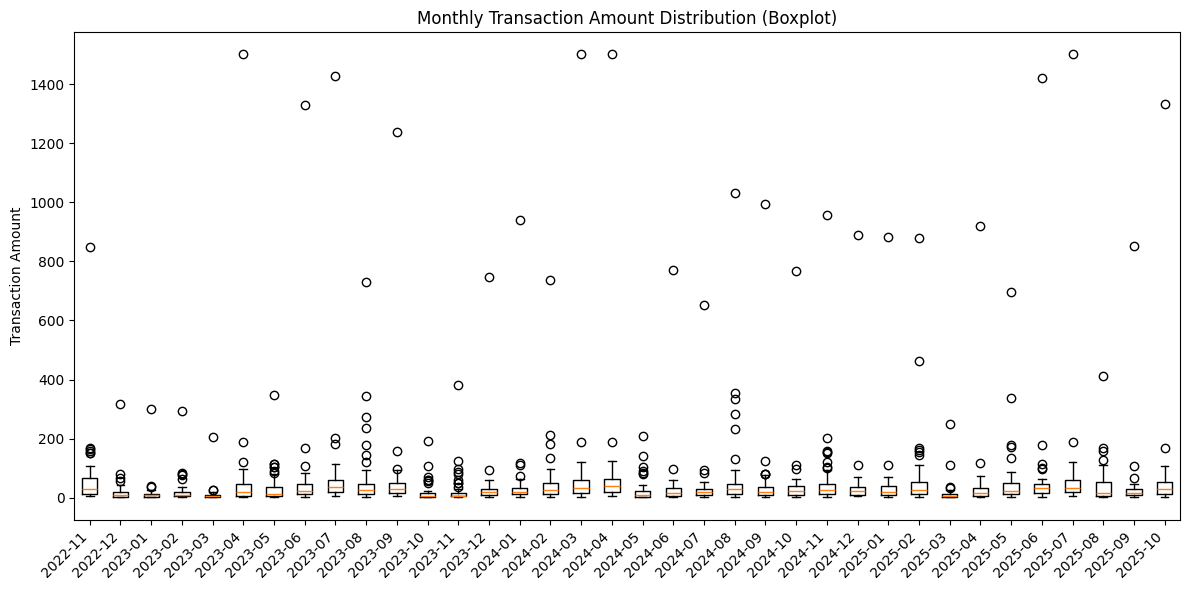

In [11]:
# Cell 8: Boxplot of transaction amounts per month (outlier view)
# Prepare a list of arrays: amounts per month
groups = []
labels = []
for ym, grp in df.groupby("year_month"):
    vals = grp["amount"].dropna().values
    if len(vals) > 0:
        groups.append(vals)
        labels.append(ym.strftime("%Y-%m"))

plt.figure(figsize=(12,6))
plt.boxplot(groups, labels=labels, showfliers=True)  # show fliers to spot outliers
plt.xticks(rotation=45, ha="right")
plt.ylabel("Transaction Amount")
plt.title("Monthly Transaction Amount Distribution (Boxplot)")
plt.tight_layout()
plt.show()


In [7]:
# Cell 9: Biggest months and largest individual transactions
print("Top 5 biggest months by total spend:")
display(monthly.nlargest(5, "amount"))

print("\nTop 10 largest transactions:")
display(df.nlargest(10, "amount")[["event_date","merchant_name","amount","cat_name"] if "cat_name" in df.columns else ["event_date","merchant_name","amount"]])


Top 5 biggest months by total spend:


,year_month,amount,ma_3,ma_6,ma_12
17,2024-04-01,3516.85,3049.156667,2365.401667,2387.740833
21,2024-08-01,3402.43,2192.320000,2418.398333,2128.046667
8,2023-07-01,3397.98,2619.180000,2026.478333,NaN
32,2025-07-01,3294.52,3025.776667,2470.890000,2447.460000
27,2025-02-01,3239.73,2382.863333,2396.913333,2407.655833



Top 10 largest transactions:


,event_date,merchant_name,amount,cat_name
250,2023-04-28 18:00:00,Property Mgmt,1500.00,RENT_AND_UTILITIES
745,2024-03-25 22:00:00,Property Mgmt,1500.00,RENT_AND_UTILITIES
786,2024-04-24 23:00:00,Apartment Rent,1500.00,RENT_AND_UTILITIES
1439,2025-07-14 02:00:00,Property Mgmt,1500.00,RENT_AND_UTILITIES
366,2023-07-12 20:00:00,Apartment Rent,1427.52,RENT_AND_UTILITIES
1412,2025-06-24 18:00:00,Apartment Rent,1420.50,RENT_AND_UTILITIES
1577,2025-10-15 19:00:00,Apartment Rent,1330.87,RENT_AND_UTILITIES
322,2023-06-06 04:00:00,Apartment Rent,1330.61,RENT_AND_UTILITIES
465,2023-09-11 04:00:00,Apartment Rent,1236.87,RENT_AND_UTILITIES
942,2024-08-04 02:00:00,Property Mgmt,1031.55,RENT_AND_UTILITIES
